In [2]:
#|default_exp core

# Core

In [3]:
#|hide
%load_ext autoreload
%autoreload 2

In [4]:
#|export
import concurrent.futures
import inspect
import reprlib
import warnings
from collections import Counter, OrderedDict
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
from numba import njit
from window_ops.shift import shift_array

In [5]:
import copy

from nbdev import show_doc
from fastcore.test import test_eq, test_fail, test_warns
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

from mlforecast.utils import generate_daily_series, generate_prices_for_series

## Data format

The required input format is a dataframe with an index named `unique_id` with a unique identifier for each time serie, a column `ds` with the datestamp and a column `y` with the values of the serie. Every other column is considered a static feature unless stated otherwise in `TimeSeries.fit`

In [6]:
series = generate_daily_series(20, n_static_features=2)
series

,ds,y,static_0,static_1
unique_id,,,,
id_00,2000-01-01,7.404529,27,53
id_00,2000-01-02,35.952624,27,53
id_00,2000-01-03,68.958353,27,53
id_00,2000-01-04,84.994505,27,53
id_00,2000-01-05,113.219810,27,53
...,...,...,...,...
id_19,2000-03-25,400.606807,97,45
id_19,2000-03-26,538.794824,97,45
id_19,2000-03-27,620.202104,97,45


For simplicity we'll just take one time serie here.

In [7]:
uids = series.index.unique(level='unique_id')
serie = series.loc[[uids[0]]]
serie

,ds,y,static_0,static_1
unique_id,,,,
id_00,2000-01-01,7.404529,27,53
id_00,2000-01-02,35.952624,27,53
id_00,2000-01-03,68.958353,27,53
id_00,2000-01-04,84.994505,27,53
id_00,2000-01-05,113.219810,27,53
...,...,...,...,...
id_00,2000-08-05,13.263188,27,53
id_00,2000-08-06,38.231981,27,53
id_00,2000-08-07,59.555183,27,53


In [8]:
#|exporti
date_features_dtypes = {
    'year': np.uint16,
    'month': np.uint8,
    'day': np.uint8,
    'hour': np.uint8,
    'minute': np.uint8,
    'second': np.uint8,
    'dayofyear': np.uint16,
    'day_of_year': np.uint16,
    'weekofyear': np.uint8,
    'week': np.uint8,
    'dayofweek': np.uint8,
    'day_of_week': np.uint8,
    'weekday': np.uint8,
    'quarter': np.uint8,
    'daysinmonth': np.uint8,
    'is_month_start': np.uint8,
    'is_month_end': np.uint8,
    'is_quarter_start': np.uint8,
    'is_quarter_end': np.uint8,
    'is_year_start': np.uint8,
    'is_year_end': np.uint8,
}


@njit
def _append_new(data, indptr, new):
    """Append each value of new to each group in data formed by indptr."""
    n_series = len(indptr) - 1
    new_data = np.empty(data.size + new.size, dtype=data.dtype)
    new_indptr = indptr.copy()
    new_indptr[1:] += np.arange(1, n_series + 1)
    for i in range(n_series):
        prev_slice = slice(indptr[i], indptr[i + 1])
        new_slice = slice(new_indptr[i], new_indptr[i + 1] - 1)
        new_data[new_slice] = data[prev_slice]
        new_data[new_indptr[i + 1] - 1] = new[i]
    return new_data, new_indptr


In [248]:
#|exporti
class GroupedArray:
    """Array made up of different groups. Can be thought of (and iterated) as a list of arrays.
    
    All the data is stored in a single 1d array `data`.
    The indices for the group boundaries are stored in another 1d array `indptr`."""
    
    def __init__(self, data: np.ndarray, indptr: np.ndarray):
        self.data = data
        self.indptr = indptr
        self.ngroups = len(indptr) - 1

    def __len__(self) -> int:
        return self.ngroups
        
    def __getitem__(self, idx: int) -> np.ndarray:
        return self.data[self.indptr[idx] : self.indptr[idx + 1]]
    
    def __setitem__(self, idx: int, vals: np.ndarray):
        if self[idx].size != vals.size:
            raise ValueError(f'vals must be of size {self[idx].size}')
        self[idx][:] = vals
        
    def take_from_groups(self, idx: Union[int, slice]) -> 'GroupedArray':
        """Takes `idx` from each group in the array."""
        ranges = [
            range(self.indptr[i], self.indptr[i + 1])[idx] for i in range(self.ngroups)
        ]
        items = [self.data[rng] for rng in ranges]
        sizes = np.array([item.size for item in items])
        data = np.hstack(items)
        indptr = np.append(0, sizes.cumsum())
        return GroupedArray(data, indptr)
        
    def append(self, new: np.ndarray) -> 'GroupedArray':
        """Appends each element of `new` to each existing group. Returns a copy."""
        if new.size != self.ngroups:
            raise ValueError(f'new must be of size {self.ngroups}')
        new_data, new_indptr = _append_new(self.data, self.indptr, new)
        return GroupedArray(new_data, new_indptr)

    def __repr__(self) -> str:
        return f'GroupedArray(ndata={self.data.size}, ngroups={self.ngroups})'

In [246]:
#|hide
# The `GroupedArray` is used internally for storing the series values and performing transformations.
data = np.arange(10, dtype=np.float32)
indptr = np.array([0, 2, 10])  # group 1: [0, 1], group 2: [2..9]
ga = GroupedArray(data, indptr)
test_eq(len(ga), 2)
test_eq(str(ga), 'GroupedArray(ndata=10, ngroups=2)')

In [224]:
#|hide
# Iterate through the groups
ga_iter = iter(ga)
np.testing.assert_equal(next(ga_iter), np.array([0, 1]))
np.testing.assert_equal(next(ga_iter), np.arange(2, 10))

In [225]:
#|hide
# Take the last two observations from every group
last_2 = ga.take_from_groups(slice(-2, None))
np.testing.assert_equal(last_2.data, np.array([0, 1, 8, 9]))
np.testing.assert_equal(last_2.indptr, np.array([0, 2, 4]))

In [226]:
#|hide
# Take the last four observations from every group. Note that since group 1 only has two elements, only these are returned.
last_4 = ga.take_from_groups(slice(-4, None))
np.testing.assert_equal(last_4.data, np.array([0, 1, 6, 7, 8, 9]))
np.testing.assert_equal(last_4.indptr, np.array([0, 2, 6]))

In [227]:
#|hide
# try to append new values that don't match the number of groups
test_fail(lambda: ga.append(np.array([1., 2., 3.])), contains='new must be of size 2')

In [229]:
#|hide
#__setitem__
new_vals = np.array([10, 11])
ga[0] = new_vals
np.testing.assert_equal(ga.data, np.append(new_vals, np.arange(2, 10)))

In [34]:
#|exporti
@njit
def _identity(x: np.ndarray) -> np.ndarray:
    """Do nothing to the input."""
    return x


def _as_tuple(x):
    """Return a tuple from the input."""
    if isinstance(x, tuple):
        return x
    return (x,)


#@njit(nogil=True)
def _transform_series(data, indptr, updates_only, lag, func, *args) -> np.ndarray:
    """Shifts every group in `data` by `lag` and computes `func(shifted, *args)`.
    
    If `updates_only=True` only last value of the transformation for each group is returned, 
    otherwise the full transformation is returned"""
    n_series = len(indptr) - 1
    if updates_only:
        out = np.empty_like(data[:n_series])
        for i in range(n_series):
            lagged = shift_array(data[indptr[i] : indptr[i + 1]], lag)
            out[i] = func(lagged, *args)[-1]        
    else:
        out = np.empty_like(data)
        for i in range(n_series):
            lagged = shift_array(data[indptr[i] : indptr[i + 1]], lag)
            out[indptr[i] : indptr[i + 1]] = func(lagged, *args)
    return out

In [16]:
#|exporti
def _build_transform_name(lag, tfm, *args) -> str:
    """Creates a name for a transformation based on `lag`, the name of the function and its arguments."""
    tfm_name = f'{tfm.__name__}_lag-{lag}'
    func_params = inspect.signature(tfm).parameters
    func_args = list(func_params.items())[1:]  # remove input array argument
    changed_params = [
        f'{name}-{value}'
        for value, (name, arg) in zip(args, func_args)
        if arg.default != value
    ]
    if changed_params:
        tfm_name += '_' + '_'.join(changed_params)
    return tfm_name


In [17]:
#|hide
test_eq(_build_transform_name(1, expanding_mean), 'expanding_mean_lag-1')
test_eq(_build_transform_name(2, rolling_mean, 7), 'rolling_mean_lag-2_window_size-7')

In [18]:
#|export
def simple_predict(
    model,
    new_x: pd.DataFrame,
    dynamic_dfs: List[pd.DataFrame],
    features_order: List[str],
    **kwargs,
) -> np.ndarray:
    """Drop the ds column from `new_x` and call `model.predict` on it."""
    new_x = new_x[features_order]
    return model.predict(new_x)


def merge_predict(
    model,
    new_x: pd.DataFrame,
    dynamic_dfs: List[pd.DataFrame],
    features_order: List[str],
    **kwargs,
) -> np.ndarray:
    """Perform left join on each of `dynamic_dfs` and call model.predict."""
    idx = new_x.index.name
    new_x = new_x.reset_index()
    for df in dynamic_dfs:
        new_x = new_x.merge(df, how='left')
    new_x = new_x.sort_values(idx)
    new_x = new_x[features_order]
    return model.predict(new_x)

In [19]:
#|exporti
def _name_models(current_names):
    ctr = Counter(current_names)
    if max(ctr.values()) < 2:
        return current_names
    names = current_names.copy()
    for i, x in enumerate(reversed(current_names), start=1):
        count = ctr[x]
        if count > 1:
            name = f'{x}{count}'
            ctr[x] -= 1
        else:
            name = x
        names[-i] = name
    return names

In [20]:
#|hide
# one duplicate
names = ['a', 'b', 'a', 'c']
expected = ['a', 'b', 'a2', 'c']
actual = _name_models(names)
assert actual == expected

# no duplicates
names = ['a', 'b', 'c']
actual = _name_models(names)
assert actual == names

In [327]:
#|exporti
@njit
def _diff(x, lag):
    y = x.copy()
    for i in range(lag):
        y[i] = np.nan
    for i in range(lag, x.size):
        y[i] = x[i] - x[i - lag]
    return y

In [321]:
#|export
class TimeSeries:
    """Utility class for storing and transforming time series data."""
    
    def __init__(
        self,
        freq: Optional[Union[int, str]] = None,
        lags: List[int] = [],
        lag_transforms: Dict[int, List[Tuple]] = {},
        date_features: List[str] = [],
        differences: Optional[List[int]] = None,
        num_threads: int = 1,
    ):
        if isinstance(freq, str):
            self.freq = pd.tseries.frequencies.to_offset(freq)
        elif isinstance(freq, int):
            self.freq = freq
        elif freq is None:
            self.freq = 1
        if not isinstance(num_threads, int) or num_threads < 1:
            warnings.warn('Setting num_threads to 1.')
            num_threads = 1
        self.differences = [] if differences is None else list(differences)
        self.num_threads = num_threads
        self.date_features = list(date_features)
        
        self.transforms: Dict[str, Tuple[Any, ...]] = OrderedDict()
        for lag in lags:
            self.transforms[f'lag-{lag}'] = (lag, _identity)
        for lag in lag_transforms.keys():
            for tfm_args in lag_transforms[lag]:
                tfm, *args = _as_tuple(tfm_args)
                tfm_name = _build_transform_name(lag, tfm, *args)
                self.transforms[tfm_name] = (lag, tfm, *args)
                
        self.ga: GroupedArray
                
    @property
    def features(self) -> List[str]:
        """Names of all computed features."""
        return list(self.transforms.keys()) + self.date_features
                
    def __repr__(self):
        return (
            f'TimeSeries(freq={self.freq}, '
            f'transforms={list(self.transforms.keys())}, '
            f'date_features={self.date_features}, '
            f'num_threads={self.num_threads})'
        )

    def _data_indptr_from_sorted_df(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        grouped = df.groupby(level=0, observed=True)
        sizes = grouped.size().values
        indptr = np.append(0, sizes.cumsum())
        data = df[self.target_col].values
        return data, indptr
        
    def _fit(
        self,
        df: pd.DataFrame,
        id_col: str = 'index',
        time_col: str = 'ds',
        target_col: str = 'y',
        static_features: Optional[List[str]] = None,
        keep_last_n: Optional[int] = None,
    ) -> 'TimeSeries':
        """Save the series values, ids and last dates."""
        if pd.api.types.is_datetime64_dtype(df[time_col]):
            if self.freq == 1:
                raise ValueError('Must set frequency when using a timestamp type column.')
        elif np.issubdtype(df[time_col].dtype.type, np.integer):
            if self.freq != 1:
                warnings.warn('Setting `freq=1` since time col is int.')
                self.freq = 1
            if self.date_features:
                warnings.warn('Ignoring date_features since time column is integer.')
        else:
            raise ValueError(f'{time_col} must be either timestamp or integer.')
        self.id_col = id_col
        self.target_col = target_col
        self.time_col = time_col
        if static_features is None:
            static_features = df.columns.drop([time_col, target_col])
        self.static_features = (
            df[static_features].groupby(level=0).head(1)
        )
        sort_idxs = pd.core.sorting.lexsort_indexer([df.index, df[time_col]])
        sorted_df = df[[time_col, target_col]].set_index(time_col, append=True).iloc[sort_idxs]
        self.restore_idxs = np.empty(df.shape[0], dtype=np.int32)        
        self.restore_idxs[sort_idxs] = np.arange(df.shape[0])        
        self.uids = sorted_df.index.unique(level=0)           
        data, indptr = self._data_indptr_from_sorted_df(sorted_df)
        self.ga = GroupedArray(data, indptr)        
        if data.dtype not in (np.float32, np.float64):
            # since all transformations generate nulls, we need a float dtype
            data = data.astype(np.float32)
        if self.differences:            
            original_sizes = indptr[1:].cumsum()
            total_diffs = sum(self.differences)
            small_series = self.uids[original_sizes < total_diffs]
            if small_series.size:
                msg = reprlib.repr(small_series.tolist())
                raise ValueError(f'The following series are too short for the differences: {msg}')
            n_series = len(indptr) - 1
            max_diff = max(self.differences)
            self.original_values_ = []
            ga = GroupedArray(data, indptr)
            new_indptr = indptr.copy()
            for d in self.differences:
                new_indptr -= d * np.arange(n_series + 1)
                new_data = np.empty_like(data, shape=data.size - n_series * d)
                new_ga = GroupedArray(new_data, new_indptr)
                orig_vals = GroupedArray(
                    np.empty_like(data, shape=n_series * d),
                    np.append(0, np.repeat(d, n_series).cumsum()),
                )
                for i in range(n_series):
                    new_ga[i] = _diff(ga[i], d)
                    orig_vals[i] = ga[i][-d:]
                ga = GroupedArray(new_data, new_indptr.copy())
                self.original_values_.append(orig_vals)
            new_restore = np.empty(new_data.size, dtype=np.int32)
            n_diffs = sum(self.differences)
            for i in range(n_series):
                new_restore[new_indptr[i] : new_indptr[i + 1]] = self.restore_idxs[self.ga.indptr[i] : self.ga.indptr[i + 1]][n_diffs:]                
            self.ga = new_ga
            self.restore_idxs = new_restore
        self.features_ = self._compute_transforms()
        if keep_last_n is not None:
            self.ga = self.ga.take_from_groups(slice(-keep_last_n, None))
        self._ga = GroupedArray(self.ga.data, self.ga.indptr)        
        self.last_dates = sorted_df.index.get_level_values(self.time_col)[indptr[1:] - 1]
        self.features_order_ = df.columns.drop([self.time_col, self.target_col]).tolist() + self.features
        return self

    def _apply_transforms(self, updates_only: bool = False) -> Dict[str, np.ndarray]:
        """Apply the transformations using the main process.
        
        If `updates_only` then only the updates are returned.
        """
        results = {}
        offset = 1 if updates_only else 0
        for tfm_name, (lag, tfm, *args) in self.transforms.items():
            results[tfm_name] = _transform_series(
                self.ga.data, self.ga.indptr, updates_only, lag - offset, tfm, *args
            )
        return results

    def _apply_multithreaded_transforms(
        self, updates_only: bool = False
    ) -> Dict[str, np.ndarray]:
        """Apply the transformations using multithreading.
        
        If `updates_only` then only the updates are returned.
        """        
        future_to_result = {}
        results = {}
        offset = 1 if updates_only else 0        
        with concurrent.futures.ThreadPoolExecutor(self.num_threads) as executor:
            for tfm_name, (lag, tfm, *args) in self.transforms.items():
                future = executor.submit(
                    _transform_series,
                    self.ga.data,
                    self.ga.indptr,
                    updates_only,
                    lag - offset,
                    tfm,
                    *args,
                )
                future_to_result[future] = tfm_name
            for future in concurrent.futures.as_completed(future_to_result):
                tfm_name = future_to_result[future]
                results[tfm_name] = future.result()
        return results
    
    def _compute_transforms(self) -> Dict[str, np.ndarray]:
        """Compute the transformations defined in the constructor.

        If `self.num_threads > 1` these are computed using multithreading."""
        if self.num_threads == 1 or len(self.transforms) == 1:
            return self._apply_transforms()
        return self._apply_multithreaded_transforms()

    def _transform(
        self,
        df: pd.DataFrame,
        dropna: bool = True,
    ) -> pd.DataFrame:
        """Add the features to `df`.
        
        if `dropna=True` then all the null rows are dropped."""
        if not self.transforms:
            raise ValueError('Must specify at least one type of transformation.')
        df = df.copy(deep=False)
        for feat in self.transforms.keys():
            df[feat] = self.features_[feat][self.restore_idxs]

        if dropna:
            df.dropna(inplace=True)

        if not isinstance(self.freq, int):
            for feature in self.date_features:
                feat_vals = getattr(df[self.time_col].dt, feature).values
                df[feature] = feat_vals.astype(date_features_dtypes[feature])
        return df
    
    def fit_transform(
        self,
        data: pd.DataFrame,
        id_col: str = 'index',
        time_col: str = 'ds',
        target_col: str = 'y',
        static_features: Optional[List[str]] = None,
        dropna: bool = True,
        keep_last_n: Optional[int] = None,
    ) -> pd.DataFrame:
        """Add the features to `data` and save the required information for the predictions step.
        
        If not all features are static, specify which ones are in `static_features`.
        If you don't want to drop rows with null values after the transformations set `dropna=False`
        If `keep_last_n` is not None then that number of observations is kept across all series for updates.
        """
        if id_col not in data and id_col != 'index':
            raise ValueError(f"Couldn't find {id_col} column.")
        for col in (time_col, target_col):
            if col not in data:
                raise ValueError(f"Data doesn't contain {col} column")
        if data[target_col].isnull().any():
            raise ValueError(f'{target_col} column contains null values.')                
        if id_col != 'index':
            data = data.set_index(id_col)                
        self._fit(data, id_col, time_col, target_col, static_features, keep_last_n)
        return self._transform(data, dropna)

    def _update_y(self, new: np.ndarray) -> None:
        """Appends the elements of `new` to every time serie.

        These values are used to update the transformations and are stored as predictions."""
        if not hasattr(self, 'y_pred'):
            self.y_pred = []
        self.y_pred.append(new)
        new_arr = np.asarray(new)
        self.ga = self.ga.append(new_arr)     
        
    def _update_features(self) -> pd.DataFrame:
        """Compute the current values of all the features using the latest values of the time series."""
        if not hasattr(self, 'curr_dates'):
            self.curr_dates = self.last_dates.copy()
            self.test_dates = []
        self.curr_dates += self.freq
        self.test_dates.append(self.curr_dates)

        if self.num_threads == 1 or len(self.transforms) == 1:
            features = self._apply_transforms(updates_only=True)
        else:
            features = self._apply_multithreaded_transforms(updates_only=True)

        if not isinstance(self.freq, int):
            for feature in self.date_features:
                feat_vals = getattr(self.curr_dates, feature).values
                features[feature] = feat_vals.astype(date_features_dtypes[feature])

        features_df = pd.DataFrame(features, columns=self.features, index=self.uids)
        nulls_in_cols = features_df.isnull().any()
        if any(nulls_in_cols):
            warnings.warn(
                f'Found null values in {", ".join(nulls_in_cols[nulls_in_cols].index)}.'
            )
        results_df = self.static_features.join(features_df)
        results_df[self.time_col] = self.curr_dates
        return results_df

    def _get_raw_predictions(self) -> np.ndarray:
        preds = np.array(self.y_pred).ravel('F')
        n_series = len(self.ga)
        h = preds.size // n_series
        n_diffs = len(self.differences) - 1
        for i, d in enumerate(reversed(self.differences)):
            n = n_diffs - i
            for j in range(n_series):
                for k in range(d):
                    preds[j * h + k] += self.original_values_[n][j][k % d]
                for k in range(d, h):
                    preds[j * h + k] += preds[j * h + k - d]
                # for k in range(h):
                #     preds[j * h + k] += self.original_values_[n][j][k % d]
        return preds
    
    def _get_predictions(self) -> pd.DataFrame:
        """Get all the predicted values with their corresponding ids and datestamps."""
        n_preds = len(self.y_pred)
        idx = pd.Index(
            np.repeat(self.uids, n_preds),
            name=self.id_col if self.id_col != 'index' else None,
            dtype=self.uids.dtype,
        )
        df = pd.DataFrame(
            {
                self.time_col: np.array(self.test_dates).ravel('F'),
                f'{self.target_col}_pred': self._get_raw_predictions(),
            },
            index=idx,
        )
        return df

    def _predict_setup(self) -> None:
        self.curr_dates = self.last_dates.copy()
        self.test_dates = []
        self.y_pred = []
        self.ga = GroupedArray(self._ga.data, self._ga.indptr)
        
    def _define_predict_fn(self, predict_fn, dynamic_dfs) -> Callable:
        if predict_fn is not None:
            return predict_fn
        if dynamic_dfs is None:
            return simple_predict
        return merge_predict
    
    def predict(
        self,
        models,
        horizon: int,
        dynamic_dfs: Optional[List[pd.DataFrame]] = None,
        predict_fn: Optional[Callable] = None,
        **predict_fn_kwargs,
    ) -> pd.DataFrame:
        """Use `model` to predict the next `horizon` timesteps."""    
        if not isinstance(models, list):
            models = [models]
        model_names = _name_models([m.__class__.__name__ for m in models])
        predict_fn = self._define_predict_fn(predict_fn, dynamic_dfs)        
        for i, model in enumerate(models):
            self._predict_setup() 
            for _ in range(horizon):
                new_x = self._update_features()
                predictions = predict_fn(
                    model,
                    new_x,
                    dynamic_dfs=dynamic_dfs,
                    features_order=self.features_order_,
                    **predict_fn_kwargs,
                )
                self._update_y(predictions)
            if i == 0:
                preds = self._get_predictions()
                preds = preds.rename(columns={f'{self.target_col}_pred': model_names[i]}, copy=False)
            else:
                preds[model_names[i]] = self._get_raw_predictions()
        return preds

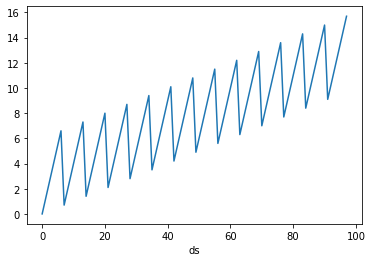

In [287]:
x = pd.DataFrame({'ds': np.arange(7 * 14), 'y': np.arange(7)[[x % 7 for x in np.arange(7 * 14)]]}, index=7 * 14 * [0])
# x = pd.DataFrame({'ds': np.arange(7 * 14), 'y': np.random.rand(7 * 14)}, index=7 * 14 * [0])
x['y'] = x['ds'] * 0.1 + x['y']
x.set_index('ds')['y'].plot();

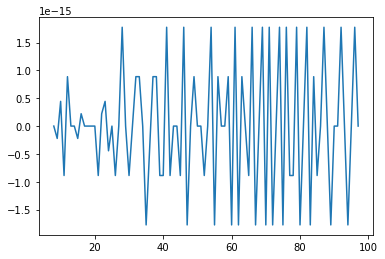

In [288]:
x['y'].diff(1).diff(7).reset_index(drop=True).plot();

<AxesSubplot:xlabel='ds'>

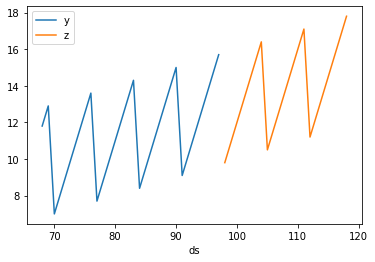

In [322]:
#|hide
# differences
ts = TimeSeries(freq=1, differences=[1, 7])._fit(x)
# np.testing.assert_allclose(
#     x['y'].diff(1).diff(7).dropna().values,
#     ts.ga.data,
# )
ts.y_pred = np.zeros(21, dtype=np.float32) # 0.1 * np.random.rand(21)
xx = ts._get_raw_predictions()
pd.concat([x.tail(30), pd.DataFrame({'ds': 1 + np.arange(21) + x['ds'].max(), 'z': xx})]).set_index('ds').plot()

The `TimeSeries` class takes care of defining the transformations to be performed (`lags`, `lag_transforms` and `date_features`). The transformations can be computed using multithreading if `num_threads > 1`.

In [ ]:
flow_config = dict(
    freq='W-THU',
    lags=[7],
    lag_transforms={
        1: [expanding_mean, (rolling_mean, 7)]
    },
    date_features=['dayofweek']
)

ts = TimeSeries(**flow_config)
ts

TimeSeries(freq=<Week: weekday=3>, transforms=['lag-7', 'expanding_mean_lag-1', 'rolling_mean_lag-1_window_size-7'], date_features=['dayofweek'], num_threads=1)

The frequency is converted to an offset.

In [ ]:
test_eq(ts.freq, pd.tseries.frequencies.to_offset(flow_config['freq']))

The date features are stored as they were passed to the constructor.

In [ ]:
test_eq(ts.date_features, flow_config['date_features'])

The transformations are stored as a dictionary where the key is the name of the transformation (name of the column in the dataframe with the computed features), which is built using `build_transform_name` and the value is a tuple where the first element is the lag it is applied to, then the function and then the function arguments.

In [ ]:
test_eq(
    ts.transforms, 
    {
        'lag-7': (7, _identity),
        'expanding_mean_lag-1': (1, expanding_mean), 
        'rolling_mean_lag-1_window_size-7': (1, rolling_mean, 7)
        
    }
)

Note that for `lags` we define the transformation as the identity function applied to its corresponding lag. This is because `_transform_series` takes the lag as an argument and shifts the array before computing the transformation.

In [ ]:
#|hide
# int y is converted to float32
serie2 = serie.copy()
serie2['y'] = serie2['y'].astype(int)
ts = TimeSeries(num_threads=1, freq='D', lags=[1])
ts._fit(serie2)
test_eq(ts.ga.data.dtype, np.float32)

In [ ]:
#|hide
# _compute_transforms
y = serie.y.values
lag_1 = shift_array(y, 1)

for num_threads in (1, 2):
    ts = TimeSeries(**flow_config)
    ts._fit(serie)
    transforms = ts._compute_transforms()

    np.testing.assert_equal(transforms['lag-7'], shift_array(y, 7))
    np.testing.assert_equal(transforms['expanding_mean_lag-1'], expanding_mean(lag_1))
    np.testing.assert_equal(transforms['rolling_mean_lag-1_window_size-7'], rolling_mean(lag_1, 7))

In [ ]:
#|hide
# update_y
ts = TimeSeries(freq='D', lags=[1])
ts._fit(serie)

max_size = np.diff(ts.ga.indptr)
ts._update_y([1])
ts._update_y([2])

test_eq(np.diff(ts.ga.indptr), max_size + 2)
test_eq(ts.ga.data[-2:], [1, 2])

In [ ]:
#|hide
# _update_features
ts = TimeSeries(**flow_config)
ts._fit(serie)
updates = ts._update_features().drop(columns='ds')

last_date = serie['ds'].max()
first_prediction_date = last_date + ts.freq
expected_idx = pd.Index(ts.uids, name='unique_id')

# these have an offset becase we can now "see" our last y value
expected = pd.DataFrame({
    'lag-7': shift_array(y, 6)[-1],
    'expanding_mean_lag-1': expanding_mean(y)[-1],
    'rolling_mean_lag-1_window_size-7': rolling_mean(y, 7)[-1],
    'dayofweek': np.uint8([getattr(first_prediction_date, 'dayofweek')])},
    index=expected_idx
)
statics = serie.tail(1).drop(columns=['ds', 'y'])
assert updates.equals(statics.join(expected))

test_eq(ts.curr_dates[0], first_prediction_date)

In [ ]:
#|hide
# _get_predictions
ts = TimeSeries(freq='D', lags=[1])
ts._fit(serie)
ts._update_features()
ts._update_y([1.])
preds = ts._get_predictions()

last_ds = serie['ds'].max()
expected_idx = serie.index.get_level_values('unique_id')[[0]]
expected = pd.DataFrame({'ds': [last_ds + ts.freq], 'y_pred': [1.]},
                        index=expected_idx)
pd.testing.assert_frame_equal(preds, expected)

In [ ]:
show_doc(TimeSeries.fit_transform)

---

### TimeSeries.fit_transform

>      TimeSeries.fit_transform (data:pandas.core.frame.DataFrame,
>                                id_col:str='index', time_col:str='ds',
>                                target_col:str='y',
>                                static_features:Optional[List[str]]=None,
>                                dropna:bool=True,
>                                keep_last_n:Optional[int]=None)

Add the features to `data` and save the required information for the predictions step.

If not all features are static, specify which ones are in `static_features`.
If you don't want to drop rows with null values after the transformations set `dropna=False`
If `keep_last_n` is not None then that number of observations is kept across all series for updates.

In [ ]:
flow_config = dict(
    freq='D',
    lags=[7, 14],
    lag_transforms={
        2: [
            (rolling_mean, 7),
            (rolling_mean, 14),
        ]
    },
    date_features=['dayofweek', 'month', 'year'],
    num_threads=2
)

ts = TimeSeries(**flow_config)
_ = ts.fit_transform(series)

The series values are stored as a GroupedArray in an attribute `ga`. If the data type of the series values is an int then it is converted to `np.float32`, this is because lags generate `np.nan`s so we need a float data type for them.

In [ ]:
np.testing.assert_equal(ts.ga.data, series.y.values)

The series ids are stored in an `uids` attribute.

In [ ]:
test_eq(ts.uids, series.index.unique())

For each time serie, the last observed date is stored so that predictions start from the last date + the frequency.

In [ ]:
test_eq(ts.last_dates, series.groupby('unique_id')['ds'].max().values)

The last row of every serie without the `y` and `ds` columns are taken as static features.

In [ ]:
assert ts.static_features.equals(series.groupby('unique_id').tail(1).drop(columns=['ds', 'y']))

If you pass `static_features` to `TimeSeries.fit_transform` then only these are kept.

In [ ]:
ts.fit_transform(series, static_features=['static_0'])

pd.testing.assert_frame_equal(
    ts.static_features,
    series.groupby('unique_id').tail(1)[['static_0']],
)

You can also specify keep_last_n in TimeSeries.fit_transform, which means that after computing the features for training we want to keep only the last n samples of each time serie for computing the updates. This saves both memory and time, since the updates are performed by running the transformation functions on all time series again and keeping only the last value (the update).

If you have very long time series and your updates only require a small sample it's recommended that you set keep_last_n to the minimum number of samples required to compute the updates, which in this case is 15 since we have a rolling mean of size 14 over the lag 2 and in the first update the lag 2 becomes the lag 1. This is because in the first update the lag 1 is the last value of the series (or the lag 0), the lag 2 is the lag 1 and so on.

In [ ]:
keep_last_n = 15

ts = TimeSeries(**flow_config)
df = ts.fit_transform(series, keep_last_n=keep_last_n)

expected_lags = ['lag-7', 'lag-14']
expected_transforms = ['rolling_mean_lag-2_window_size-7', 
                       'rolling_mean_lag-2_window_size-14']
expected_date_features = ['dayofweek', 'month', 'year']

test_eq(ts.features, expected_lags + expected_transforms + expected_date_features)
test_eq(ts.static_features.columns.tolist() + ts.features, df.columns.drop(['ds', 'y']).tolist())
# we dropped 2 rows because of the lag 2 and 13 more to have the window of size 14
test_eq(df.shape[0], series.shape[0] - (2 + 13) * ts.ga.ngroups)
test_eq(ts.ga.data.size, ts.ga.ngroups * keep_last_n)

`TimeSeries.fit_transform` requires that the *y* column doesn't have any null values. This is because the transformations could propagate them forward, so if you have null values in the *y* column you'll get an error.

In [ ]:
series_with_nulls = series.copy()
series_with_nulls.iloc[1, 1] = np.nan
test_fail(lambda: ts.fit_transform(series_with_nulls), contains='y column contains null values')

In [ ]:
#|hide
# unsorted df
ts = TimeSeries(**flow_config)
df = ts.fit_transform(series)
unordered_series = series.sample(frac=1.0)
assert not unordered_series.set_index('ds', append=True).index.is_monotonic_increasing
df2 = ts.fit_transform(unordered_series)
pd.testing.assert_frame_equal(df, df2.sort_values(['unique_id', 'ds']))

In [ ]:
#|hide
# non-standard df
ts = TimeSeries(**flow_config)
df = ts.fit_transform(series)
non_std_series = series.reset_index().rename(columns={'unique_id': 'some_id', 'ds': 'timestamp', 'y': 'value'})
non_std_res = ts.fit_transform(non_std_series, id_col='some_id', time_col='timestamp', target_col='value')
non_std_res.index.name = 'unique_id'
pd.testing.assert_frame_equal(
    df,
    non_std_res.rename(columns={'timestamp': 'ds', 'value': 'y'})
)

In [ ]:
#|hide
# integer timestamps
flow_config_int_ds = copy.deepcopy(flow_config)
flow_config_int_ds['date_features'] = []
del flow_config_int_ds['freq']
ts = TimeSeries(**flow_config_int_ds)
int_ds_series = series.copy()
int_ds_series['ds'] = int_ds_series['ds'].astype('int64')
int_ds_res = ts.fit_transform(int_ds_series)
int_ds_res['ds'] = pd.to_datetime(int_ds_res['ds'])
pd.testing.assert_frame_equal(
    df.drop(columns=flow_config['date_features'] + ['ds']),
    int_ds_res.drop(columns='ds')
)

In [ ]:
show_doc(TimeSeries.predict)

---

### TimeSeries.predict

>      TimeSeries.predict (models, horizon:int,
>                          dynamic_dfs:Optional[List[pandas.core.frame.DataFrame
>                          ]]=None, predict_fn:Optional[Callable]=None,
>                          **predict_fn_kwargs)

Use `model` to predict the next `horizon` timesteps.

Once we have a trained model we can use `TimeSeries.predict` passing the model and the horizon to get the predictions back.

In [ ]:
class DummyModel:
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        return X['lag-7'].values

horizon = 7
model = DummyModel()
ts = TimeSeries(**flow_config)
ts.fit_transform(series)
predictions = ts.predict(model, horizon)

grouped_series = series.groupby('unique_id')
expected_preds = grouped_series['y'].tail(7)  # the model predicts the lag-7
last_dates = grouped_series['ds'].max()
expected_dsmin = last_dates + ts.freq
expected_dsmax = last_dates + horizon * ts.freq
grouped_preds = predictions.groupby('unique_id')

assert predictions['DummyModel'].equals(expected_preds)
assert grouped_preds['ds'].min().equals(expected_dsmin)
assert grouped_preds['ds'].max().equals(expected_dsmax)

In [ ]:
#|hide
model = DummyModel()
ts = TimeSeries(**flow_config)
ts.fit_transform(series)
predictions = ts.predict(model, horizon=horizon)
ts = TimeSeries(**flow_config_int_ds)
ts.fit_transform(int_ds_series)
int_ds_predictions = ts.predict(model, horizon=horizon)
pd.testing.assert_frame_equal(predictions.drop(columns='ds'), int_ds_predictions.drop(columns='ds'))

If we have dynamic features we can pass them to `dynamic_dfs`.

In [ ]:
class PredictPrice:
    def predict(self, X):
        return X['price']

series = generate_daily_series(20, n_static_features=2, equal_ends=True)
dynamic_series = series.rename(columns={'static_1': 'product_id'})
prices_catalog = generate_prices_for_series(dynamic_series)
series_with_prices = dynamic_series.reset_index().merge(prices_catalog, how='left')
series_with_prices.set_index('unique_id', inplace=True)

model = PredictPrice()
ts = TimeSeries(**flow_config)
ts.fit_transform(series_with_prices, static_features=['static_0', 'product_id'])
predictions = ts.predict(model, horizon=1, dynamic_dfs=[prices_catalog])

expected_prices = series_with_prices.reset_index()[['unique_id', 'product_id']].drop_duplicates()
expected_prices['ds'] = series_with_prices['ds'].max() + ts.freq
expected_prices = expected_prices.reset_index()
expected_prices = expected_prices.merge(prices_catalog, on=['product_id', 'ds'], how='left')
expected_prices = expected_prices.set_index('unique_id')[['ds', 'price']]

assert predictions.rename(columns={'PredictPrice': 'price'}).equals(expected_prices)